Here I do the necessary imports for my investigation into the apex of League of Legends ranked players :3


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import time
from scipy import stats
from datetime import datetime
import warnings

Here is my old api key and the base url for all api calls

In [3]:
# API config
API_KEY = "RGAPI-c0d8a222-1904-47af-8dfc-9a30b5036e81"
BASE_URL = {'na1': 'https://na1.api.riotgames.com'}

Here I define the riotAPI class that makes the API calls with the rate limits so
that I do not get error 403'd by Riot Games.

In [4]:
class RiotAPI:
    def __init__(self, api_key):
        self.api_key = api_key
        self.request_count = 0
        self.last_request_time = 0
        self.requests_this_minute = 0
        self.minute_start = time.time()

    # in this method i make the api requests while handling rate limits
    def make_request(self, url, params=None):
        current_time = time.time()

        # reset timer if > 2 minutes
        if current_time - self.minute_start > 120:
            self.requests_this_minute = 0
            self.minute_start = current_time

        # max 100 requests per 2 minutes (due to riot rate limits) w/ a buffer
        if self.requests_this_minute >= 99:
            wait_time = (120 - (current_time - self.minute_start) + 5)
            if wait_time > 0:
                print(f"Limit reached. Wait {wait_time:.1f} seconds")
                time.sleep(wait_time)
                self.requests_this_minute = 0
                self.minute_start = time.time()

        # max 20 requests per second (due to riot rate limits)
        time_since_last = current_time - self.last_request_time
        if time_since_last < 0.05:
            time.sleep(0.05 - time_since_last)

        if params is None:
            params = {}
        params['api_key'] = self.api_key

        response = requests.get(url, params=params)
        self.request_count += 1
        self.requests_this_minute += 1
        self.last_request_time = time.time()

        if response.status_code == 200:
          return response.json()
        else:
          print(f"Request failed: {response.status_code}")
          return None

    #in this method i get the challenger players for the provided region (america)
    def get_challenger_players(self, region='na1'):
        url = f"{BASE_URL[region]}/lol/league/v4/challengerleagues/by-queue/RANKED_SOLO_5x5"
        return self.make_request(url)

    # in this method i get match history via the player uid (unused; could be useful for future analysis)
    def get_match_history(self, puuid, start=0, count=20, region='americas'):
        url = f"{BASE_URL[region]}/lol/match/v5/matches/by-puuid/{puuid}/ids"
        params = {'start': start, 'count': count}
        return self.make_request(url, params)

    # in this method i get the summoner info via their player uid
    def get_summoner_by_puuid(self, puuid, region='na1'):
      url = f"{BASE_URL[region]}/lol/summoner/v4/summoners/by-puuid/{puuid}"
      return self.make_request(url)

    #in this method i get match information from the api via matchid (unused; could be useful for future analysis)
    def get_match_details(self, match_id, region='americas'):
        url = f"{BASE_URL[region]}/lol/match/v5/matches/{match_id}"
        return self.make_request(url)

Here I print the first player (to see what the data structure looks like), and then I load all 300 challenger players in North America. I load 300 since there are only 300 challenger slots allowed at one time. For context, incase you have never played League of Legends before, challenger is the highest rank achievable, and there are only 300 spaces allowed per region (e.g. North America, Europe, China, Korea, etc.). Then I save it into a dataframe.

In [5]:
riot_api = RiotAPI(API_KEY)

# Get challenger data
test_data = riot_api.get_challenger_players()

print(f"Found {len(test_data['entries'])} challenger players")

# shows the first player data structure
print(f"\nFull first player data:")
first_player = test_data['entries'][0]
print(json.dumps(first_player, indent=2))

# collect data using the keys
players_data = []

# Process all 300 challenger players
for i, player in enumerate(test_data['entries'][:300]):
    print(f"Processing player {i+1}/300")

    # Get summoner info using PUUID
    summoner_info = riot_api.get_summoner_by_puuid(player['puuid'])
    summoner_name = summoner_info.get('name', f'Player_{i+1}')
    player_data = {
        'puuid': player['puuid'],
        'summoner_name': summoner_name,
        'tier': 'CHALLENGER',
        'rank': player.get('rank', 'I'),
        'league_points': player['leaguePoints'],
        'wins': player['wins'],
        'losses': player['losses'],
        'win_rate': round(player['wins'] / (player['wins'] + player['losses']) * 100, 2),
        'veteran': player.get('veteran', False),
        'inactive': player.get('inactive', False),
        'fresh_blood': player.get('freshBlood', False),
        'hot_streak': player.get('hotStreak', False)
    }
    players_data.append(player_data)
    print(f"Added: {summoner_name}")

# Convert to DataFrame
df_players = pd.DataFrame(players_data)

print(f"\nCollected data for {len(df_players)} players")
print(f"Total API requests made: {riot_api.request_count}")

Found 300 challenger players

Full first player data:
{
  "puuid": "rzW2Enb6U6SQl0sL6wUG0bw7THvYtxYVaN_tKOrpC6LRNNFjtlma1CGdMJAxMBGOHsamW82rr3JqZQ",
  "leaguePoints": 2142,
  "rank": "I",
  "wins": 318,
  "losses": 214,
  "veteran": true,
  "inactive": false,
  "freshBlood": false,
  "hotStreak": true
}
Processing player 1/300
Added: Player_1
Processing player 2/300
Added: Player_2
Processing player 3/300
Added: Player_3
Processing player 4/300
Added: Player_4
Processing player 5/300
Added: Player_5
Processing player 6/300
Added: Player_6
Processing player 7/300
Added: Player_7
Processing player 8/300
Added: Player_8
Processing player 9/300
Added: Player_9
Processing player 10/300
Added: Player_10
Processing player 11/300
Added: Player_11
Processing player 12/300
Added: Player_12
Processing player 13/300
Added: Player_13
Processing player 14/300
Added: Player_14
Processing player 15/300
Added: Player_15
Processing player 16/300
Added: Player_16
Processing player 17/300
Added: Player_17

# **First Conclusion:**

In this section, in order to begin analyzing the dataset, I first calculate the basic descriptive statistics of the dataset. The findings are that the average win rate among the 300 challengers in North America is 55.7%, with a standard deviation of 3.5%. The range in LP was from 795 to 2095, which shows a massive spread in how much league points a challenger player can have. The mean LP is 1095, so it is possible that the values around 2000 are outliers in the dataset. In the dataset, it is also true that the mean number of games is 452 with a standard deviation of 207, so the 'average' number of games played so far this season by a challenger north american player is 452, but the standard deviation is quite large at 207 games, so there is a lot of variance in that dataset. The minimum and maximum number of games played is 131 and 1256 respectively.

In addition, both the win rate histogram and the league points histogram are right skewed, which indicates that only a few players even in challenger have a win rate higher than 55, and most players in challenger have a win rate around the mean, with a few vastly above it. This indicates that a small group of players with extremely high LP and win rate values is pulling the mean of each histogram to the right. Similarly, below is also a box and whisker plot showing the win rates and LP data, with the LP scaled down by 2000 to fit on the same plot. Lastly, there is a scatter plot that shows total games played vs win rate, with the color being mapped to the LP. At first glance, this plot shows no strong linear correlation between games played and LP, and high LP (dark purple) seems to be more correlated with high win rate and more games played, which suggests that in order to hit challenger, one must either win the vast majority of the games that they play or one must consistently win a majority of the games played and simply play a lot of games as well.

Dataset shape: (300, 14)
Columns: ['puuid', 'summoner_name', 'tier', 'rank', 'league_points', 'wins', 'losses', 'win_rate', 'veteran', 'inactive', 'fresh_blood', 'hot_streak', 'total_games', 'games_per_lp']
dataset:
                                                 puuid summoner_name  \
0    rzW2Enb6U6SQl0sL6wUG0bw7THvYtxYVaN_tKOrpC6LRNN...      Player_1   
1    okWVsNjqFLZG-33IfgQVfNILcXFfGbnWVhb-eRVRlfPl3l...      Player_2   
2    vp8Sk3j6Q8b4rH1bdIR4Y-CfzvBin-BsyiYY9hPHUvjQ17...      Player_3   
3    av40uCUK2Q27hs5L1ZaHkZ0gnMF7wdFWjpfHVvOADX9X71...      Player_4   
4    HQfHHYVp6D_30be8sKbGkW2BB3jwXZ2rKSChpzvmCGl_jN...      Player_5   
..                                                 ...           ...   
295  3RNGy0VEa4Pa5UYlK0UvP_BdeOFKsiLcNERaCHzPRHwRDI...    Player_296   
296  PR9Gapx3lfz57v5tAfxs2a5wHKaKF_Z5MMVLrRAnYMY4Fc...    Player_297   
297  AxeZTnxFBXodh881pDULCuZ6oFZ5B0mRdCBnrbmJvYVWYl...    Player_298   
298  KI7xfOR8wrPVdWminrzssFZ5dU8duGGwWkDIjch1T9QN45...    Player

/tmp/ipython-input-6-3633559795.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1,0].boxplot(box_data, labels=['Win Rate', 'LP (divided by 2000)'])


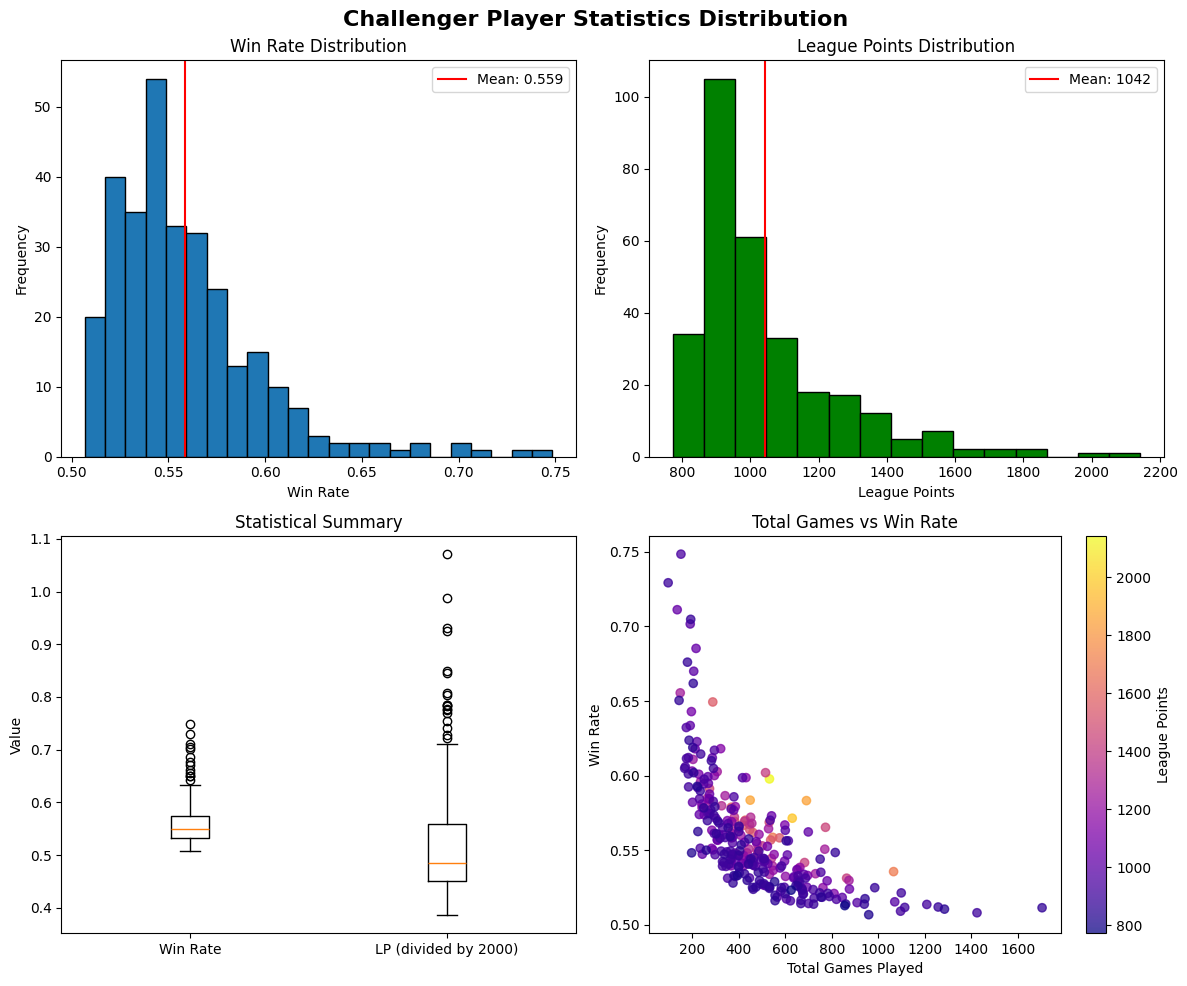

In [6]:
# Calculate stats for each challenger player
df_players['total_games'] = df_players['wins'] + df_players['losses']
df_players['win_rate'] = df_players['wins'] / df_players['total_games']
df_players['games_per_lp'] = df_players['total_games'] / df_players['league_points']

# show df_players info:
print(f"Dataset shape: {df_players.shape}")
print(f"Columns: {list(df_players.columns)}")
print("dataset:")
print(df_players)
print("\nSummary stats:")
print(df_players.describe())

# Analysis:
# Method 1: Describing the players
print("\n1. Descriptive statistics:")
print(f"Average win rate: {df_players['win_rate'].mean():.3f} ± {df_players['win_rate'].std():.3f}")
print(f"League points range: {df_players['league_points'].min()} - {df_players['league_points'].max()}")
print(f"Most games played: {df_players['total_games'].max()}")

# first (of many) beautiful plot: Distributions of WR and LP
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Challenger Player Statistics Distribution', fontsize=16, fontweight='bold')

# Win rate distribution (tried to make each bin ~1% wr)
axes[0,0].hist(df_players['win_rate'], bins=23, edgecolor = 'black')
axes[0,0].axvline(df_players['win_rate'].mean(), color='red', linestyle='-', label=f'Mean: {df_players["win_rate"].mean():.3f}')
axes[0,0].set_title('Win Rate Distribution')
axes[0,0].set_xlabel('Win Rate')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()

# League points distribution (each bin ~100LP)
axes[0,1].hist(df_players['league_points'], bins=15, color='#008000', edgecolor='black')
axes[0,1].axvline(df_players['league_points'].mean(), color='red', linestyle='-', label=f'Mean: {df_players["league_points"].mean():.0f}')
axes[0,1].set_title('League Points Distribution')
axes[0,1].set_xlabel('League Points')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()

# Box plots (with LP scaled down by 2k so they fit in the same plot)
box_data = [df_players['win_rate'], df_players['league_points']/2000]
axes[1,0].boxplot(box_data, labels=['Win Rate', 'LP (divided by 2000)'])
axes[1,0].set_title('Statistical Summary')
axes[1,0].set_ylabel('Value')

# Total games vs win rate (chose plasma for colormapping since it looks nice)
scatter = axes[1,1].scatter(df_players['total_games'], df_players['win_rate'],
                           c=df_players['league_points'], cmap='plasma', alpha=0.75)
axes[1,1].set_title('Total Games vs Win Rate')
axes[1,1].set_xlabel('Total Games Played')
axes[1,1].set_ylabel('Win Rate')
plt.colorbar(scatter, ax=axes[1,1], label='League Points')
plt.tight_layout(pad = 1.0)
plt.show()

# **Conclusion 2:**

In order to further explore the relationship between the numerical variables listed above, I computed and display here a Pearson correlation matrix using League Points, wins, losses, total games played, and win rate for the same challenger players in North America. I then visualise this using reverse inferno coloring, so a darker color for the box means there is a stronger correlation between the two. As you can see, the diagonal of the box (top left to bottom right) all has a correlation coefficient of 1, which is expected as every variable should be strongly correlated with itself. In addition, the other observed strong correlations are between total games and wins (~0.997), and total games and losses (0.997). This is to be expected since wins as well as losses are a component of total games played. Losses are also strongly correlated with wins (0.9896) which makes sense since as a person wins more if their win rate is around 50%, which it will be due to matchmaking, their loss ratio will also trend towards 50%.

**More interestingly, League points are weakly positively correlated with win rate, total games, losses, and wins** (0.1550, 0.0525, 0.0113, and 0.0939 respectively). LP and win rate have the strongest correlation coefficient out of these, which makes sense since a higher win rate would lead to more LP in a lot of cases. This suggests that LP is influenced by factors other than simply wins, losses, total wins, and surprisingly even win rate. Some other important factors that influence LP could be how long someone has been playing the game, the lp of their opponents in each game, and if they are on a hot streak.

**Lastly, there is a strong negative correlation between total games played and win rate(-0.692)**. This correlation has a p-value of ~0.0000, which is most definitely lower than the critical value alpha = 0.05. This indicates that it is not simply by pure chance, and this also points towards the fact that as someone plays more and more games, their win rate would trend down, likely because of the fact that the matchmaking system attempts to put equal skilled players in the same game, so as someone plays more and more games their win rate would equalize to 50% over time, even for challenger players. This suggests that once again, like our first conclusion, the two main ways that people typically get to challenger are either to grind out many games at a slightly lower win rate (still above 50% though) or to simply have a high win rate with a lower number of games played.


2. correlation analysis:


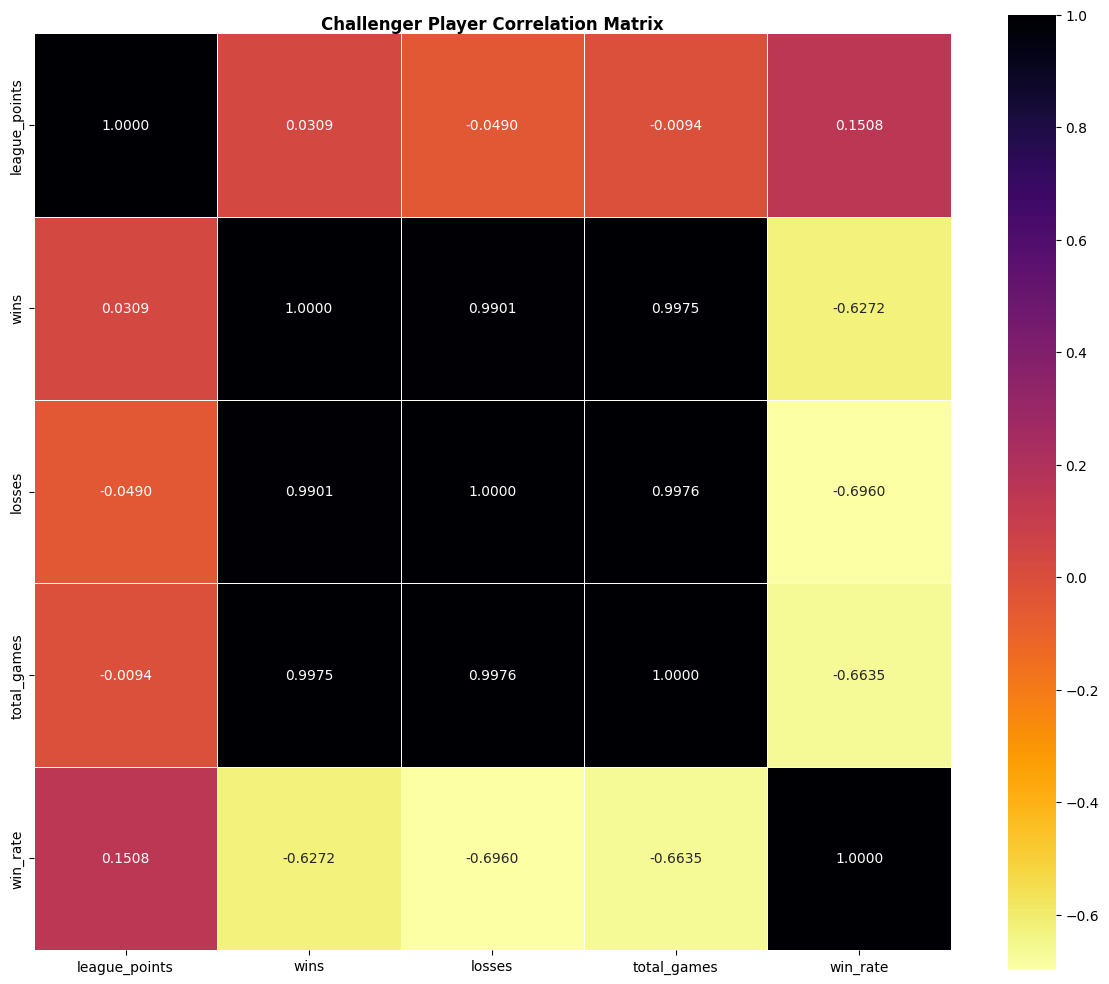

Games-Win Rate correlation: r=-0.664, p=0.0000


In [7]:
# Method 2: analysing for correlation
print("\n2. correlation analysis:")
numeric_cols = ['league_points', 'wins', 'losses', 'total_games', 'win_rate']
correlation_matrix = df_players[numeric_cols].corr()

# second dazzling plot: Correlation Heatmap
plt.figure(figsize=(12, 10))

# not exactly relevant but reverse inferno looks nice on the colormap here
sns.heatmap(correlation_matrix,annot=True, cmap='inferno_r',
            square=True, linewidths=0.5, fmt='.4f')

plt.title('Challenger Player Correlation Matrix',fontweight='bold', pad=1.0)
plt.tight_layout()
plt.show()

# show p value for games-win rate correlation
corr_games_wr, p_games_wr = stats.pearsonr(df_players['total_games'], df_players['win_rate'])
print(f"Games-Win Rate correlation: r={corr_games_wr:.3f}, p={p_games_wr:.4f}")

# **Conclusion 3: **

In order to test the data further, I conducted two hypothesis tests involving the win rates and the LP of challenger players in North America. **First, I tested the hypothesis that: "win rate is strongly correlated with league points."** Via Pearson correlation, I found a coefficient of 0.1550 and a p-value of 0.0071, which is lower than the critical value of alpha=0.05. This means that it was not due to chance, and we can accept that hypothesis that there is a statistically significant correlation between win rate and league points. However, while the correlation is statistically significant, the residual plot shows that win rate by itself is a weak predictor of LP. This support our findings and the earlier two conclusions.

In addition, I also tested the hypothesis that: "veteran players will have a different win rate than non-veteran players." I compared the mean win rates of veteran and non-veteran players out of the 300 North American Challengers using the provided tag from the Riot API and a two sample t test. "Veteran" in the Riot API context means an account that has played 100 games in the specified division (challenger in this case). The finding were that veteran players had a mean win rate of 55.2% and non-veteran players had a mean win rate of 56.1%. The p-value for this test was 0.0172, which is lower than the critical value of 0.05, which means we can accept the hypothesis that veteran players will have a different win rate than non-veteran players. Suprisingly, the mean win rate for non-veteran players was higher as opposed to veteran players. This suggests that newer players in challenger (<100 games played) have a higher win rate than players with over 100 games in challenger. This is likely because veteran players would have played more games in challenger, and since there is higher competition in challenger as the skill level is the highest there compared to all other ranks, thus their win rate would drop as a result of harder matches. Another possible explanation is that in order for a player who is not challenger to get challenger, they must first establish a high win rate in order to climb out of grandmaster in the first place. Thus, it could also be selection bias.

 First Hypothesis: Win rate is strongly correlated with league points
Pearson correlation coefficient: 0.1508
P-value: 0.0089
Result: statistically significant correlation was found ( 0.0089 < 0.05)
Hypothesis for second test: veterans will have a different win rate from non-veteran players (in challenger)

Veteran vs Non-veteran win rate comparison:
Veteran mean win rate: 0.552
Non-veteran mean win rate: 0.563
T-test p-value: 0.0176
Result: statistically significant correlation was found ( 0.0176 < 0.05)


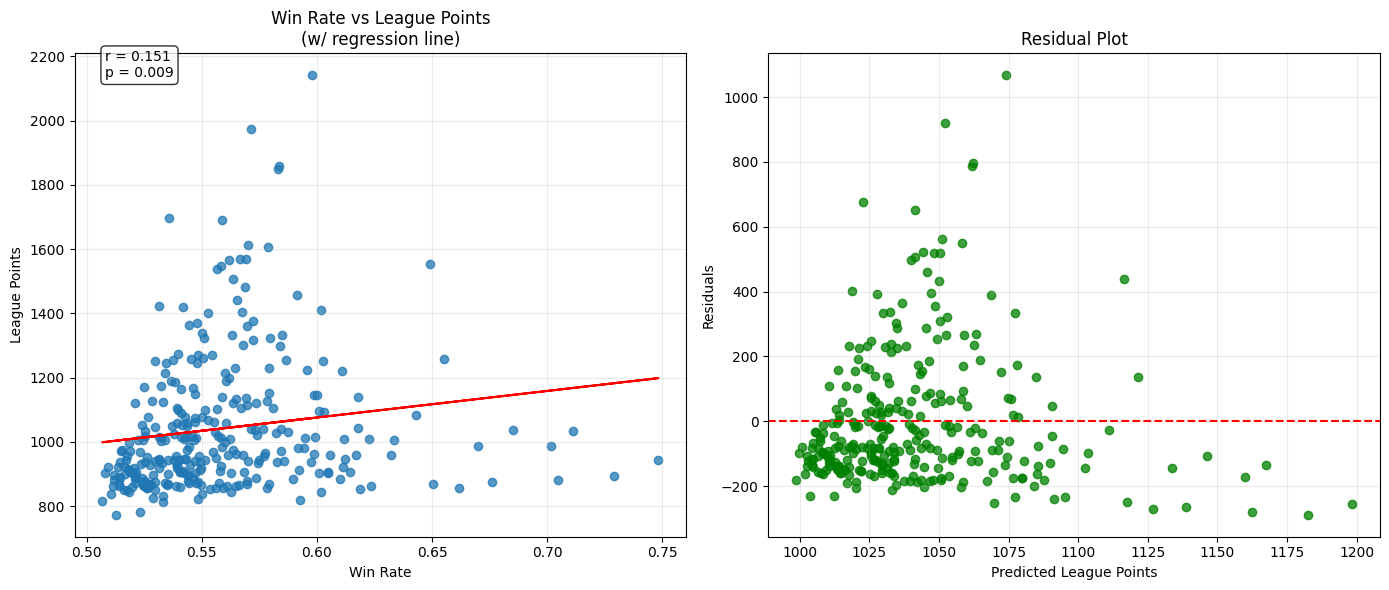

Data saved to challenger_players_data.csv


In [8]:
# Method 3: Hypothesis testing
print(" First Hypothesis: Win rate is strongly correlated with league points")

# calculate and print pearson correlation coefficient
corr_coeff, p_value = stats.pearsonr(df_players['win_rate'], df_players['league_points'])
print(f"Pearson correlation coefficient: {corr_coeff:.4f}")
print(f"P-value: {p_value:.4f}")

# compare the p value to alpha = 0.05 (for statistical significance)
if p_value < 0.05:
    print(f"Result: statistically significant correlation was found ({p_value: .4f} < 0.05)")
else:
    print(f"Result: no statistically significant correlation was found ({p_value: .4f} >= 0.05)")

# second hypothesis test: Compare veteran vs non-veteran players and check if its statistically significant
print("Hypothesis for second test: veterans will have a different win rate from non-veteran players (in challenger)")
veteran_wr = df_players[df_players['veteran'] == True]['win_rate']
non_veteran_wr = df_players[df_players['veteran'] == False]['win_rate']
t_stat, t_p_value = stats.ttest_ind(veteran_wr, non_veteran_wr)
print(f"\nVeteran vs Non-veteran win rate comparison:")
print(f"Veteran mean win rate: {veteran_wr.mean():.3f}")
print(f"Non-veteran mean win rate: {non_veteran_wr.mean():.3f}")
print(f"T-test p-value: {t_p_value:.4f}")
if t_p_value < 0.05:
    print(f"Result: statistically significant correlation was found ({t_p_value: .4f} < 0.05)")
else:
    print(f"Result: no statistically significant correlation was found ({t_p_value: .4f} >= 0.05)")

# third stunning plot: linear regression and residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot WR vs LP w/ regression line
axes[0].scatter(df_players['win_rate'], df_players['league_points'], alpha=0.75)
z = np.polyfit(df_players['win_rate'], df_players['league_points'], 1)
p = np.poly1d(z)
axes[0].plot(df_players['win_rate'], p(df_players['win_rate']), "r-")
axes[0].set_xlabel('Win Rate')
axes[0].set_ylabel('League Points')
axes[0].set_title('Win Rate vs League Points\n(w/ regression line)')
axes[0].grid(True, alpha=0.25)

# Add label box in top right corner
axes[0].text(0.05, 0.95, f'r = {corr_coeff:.3f}\np = {p_value:.3f}',
             transform=axes[0].transAxes,bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# create the residual plot (actual vals - predicted from regression line)
predicted = p(df_players['win_rate'])
residuals = df_players['league_points'] - predicted
axes[1].scatter(predicted, residuals, alpha=0.75, color='#008000')
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted League Points')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.25)

plt.tight_layout()
plt.show()

# save data to a .csv file for future use
df_players.to_csv('challenger_players_data.csv')
print("Data saved to challenger_players_data.csv")

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

#define the features (wr, games, veterancy, etc.) and the target (LP)
df = pd.read_csv('challenger_players_data.csv')
features = ['win_rate', 'total_games', 'veteran', 'hot_streak', 'fresh_blood']
X = df[features].copy()
y = df['league_points']

# convert booleans to int and then create the 80-20 train-test split
X[['veteran', 'hot_streak', 'fresh_blood']] = X[['veteran', 'hot_streak', 'fresh_blood']].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create linear regression model and use it to predict the output of the test data
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
print(df.head())

# calculate the r^2 and mean squared error for the linear regression model and then print
r2_lin = r2_score(y_test, y_pred_lin)
mse_lin = mean_squared_error(y_test, y_pred_lin)
print("Linear Regression:")
print(f"  R² Score: {r2_lin:.4f}")
print(f"  Mean Squared Error: {mse_lin:.2f}\n")

# create a random forest model and use that to predict the output of the test data
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

# calculate the r^2 score and MSE for the random forest model
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Random Forest Regressor:")
print(f"  R² Score: {r2_rf:.4f}")
print(f"  Mean Squared Error: {mse_rf:.2f}\n")

   Unnamed: 0                                              puuid  \
0           0  rzW2Enb6U6SQl0sL6wUG0bw7THvYtxYVaN_tKOrpC6LRNN...   
1           1  okWVsNjqFLZG-33IfgQVfNILcXFfGbnWVhb-eRVRlfPl3l...   
2           2  vp8Sk3j6Q8b4rH1bdIR4Y-CfzvBin-BsyiYY9hPHUvjQ17...   
3           3  av40uCUK2Q27hs5L1ZaHkZ0gnMF7wdFWjpfHVvOADX9X71...   
4           4  HQfHHYVp6D_30be8sKbGkW2BB3jwXZ2rKSChpzvmCGl_jN...   

  summoner_name        tier rank  league_points  wins  losses  win_rate  \
0      Player_1  CHALLENGER    I           2142   318     214  0.597744   
1      Player_2  CHALLENGER    I           1974   360     270  0.571429   
2      Player_3  CHALLENGER    I           1860   262     187  0.583519   
3      Player_4  CHALLENGER    I           1850   403     288  0.583213   
4      Player_5  CHALLENGER    I           1698   571     495  0.535647   

   veteran  inactive  fresh_blood  hot_streak  total_games  games_per_lp  
0     True     False        False        True          532      0

In [27]:
from xgboost import XGBRegressor

# Here i create an extreme gradient boosting model and use it to predict the same test data
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# here i print out the r^2 score and mean squared error for the XGBoost model
print("XGBoost Regressor:")
print(f"  R² Score: {r2_score(y_test, y_pred_xgb):.4f}")
print(f"  MSE: {mean_squared_error(y_test, y_pred_xgb):.2f}")

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

#scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the SVR model, then predict test data
svr = SVR(kernel='rbf')
svr.fit(X_train_scaled, y_train)
y_pred_svr = svr.predict(X_test_scaled)

# Print the r^2 and mean squared error
print("SVR (RBF Kernel) with Scaling:")
print(f"R² Score: {r2_score(y_test, y_pred_svr):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_svr):.2f}")

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)
y_pred_poly = poly_model.predict(X_test)

print("Polynomial Regression (degree=2):")
print(f"  R² Score: {r2_score(y_test, y_pred_poly):.4f}")
print(f"  MSE: {mean_squared_error(y_test, y_pred_poly):.2f}")


XGBoost Regressor:
  R² Score: 0.3868
  MSE: 24244.41
SVR (RBF Kernel) with Scaling:
R² Score: 0.0004
MSE: 39520.06
Polynomial Regression (degree=2):
  R² Score: 0.5379
  MSE: 18271.08


In [28]:
for degree in [2, 3, 4, 5]:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Degree {degree} Polynomial Regression:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MSE: {mse:.2f}\n")

Degree 2 Polynomial Regression:
  R² Score: 0.5379
  MSE: 18271.08

Degree 3 Polynomial Regression:
  R² Score: 0.5508
  MSE: 17760.05

Degree 4 Polynomial Regression:
  R² Score: 0.4784
  MSE: 20622.49

Degree 5 Polynomial Regression:
  R² Score: 0.5318
  MSE: 18513.00



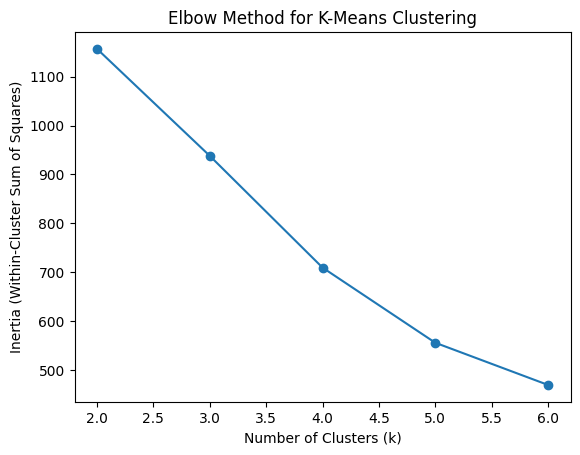

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Try clustering with K=2 to K=6
inertia = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

#plot the inertia for each K
plt.plot(range(2, 7), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for K-Means Clustering')
plt.show()

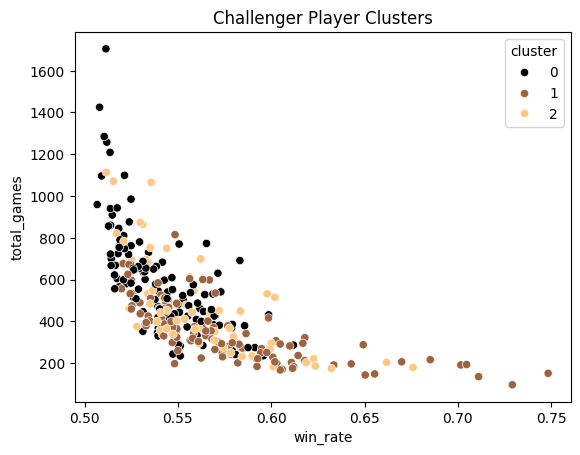

         league_points  win_rate  total_games
cluster                                      
0          1086.584615  0.542341   578.284615
1           965.149533  0.577114   346.981308
2          1079.031746  0.561450   479.920635


In [30]:
# Do kmeans with k = 3
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

#add cluster catagory to the dataframe
df['cluster'] = clusters

#create a scatterplot with the color being their cluster
sns.scatterplot(data=df, x='win_rate', y='total_games', hue='cluster', palette='copper')
plt.title('Challenger Player Clusters')
plt.show()

#use groupby to show the mean LP, WR, and TotalGames for each cluster and print
cluster_summary = df.groupby('cluster')[['league_points', 'win_rate', 'total_games']].mean()
print(cluster_summary)

Linear Regression with Cluster Feature:
  R² Score: 0.3933
  Mean Squared Error: 23988.98

Polynomial Regression (degree=2) with Cluster Feature:
  R² Score: 0.5327
  Mean Squared Error: 18475.23
Random Forest Regressor with Cluster Feature:
  R² Score: 0.4433
  Mean Squared Error: 22010.73


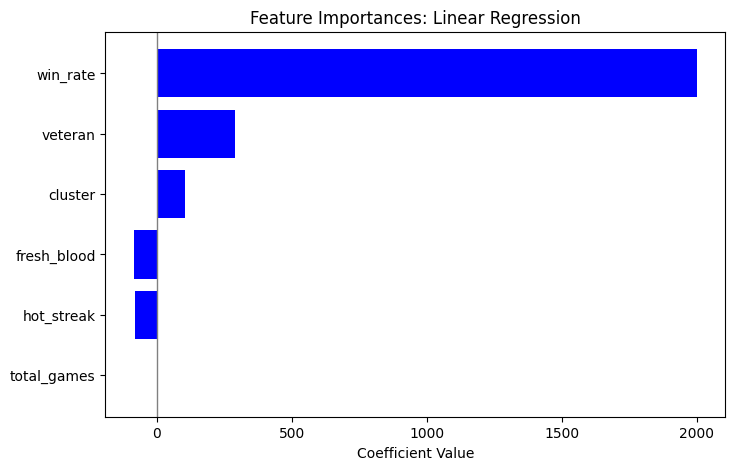

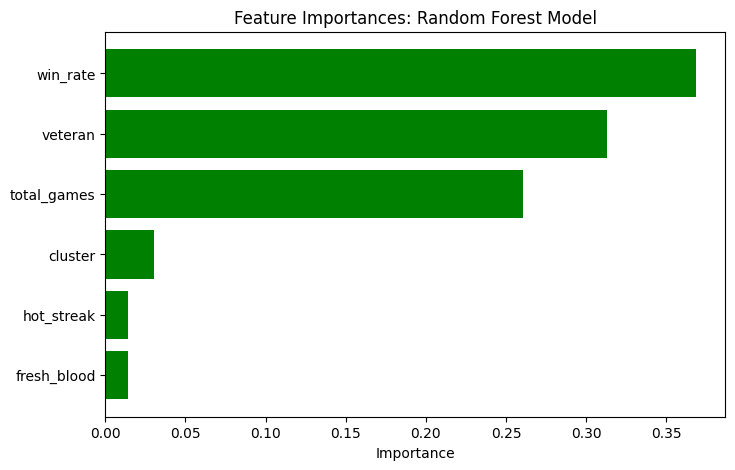

In [38]:
X = df[['win_rate', 'total_games', 'veteran', 'hot_streak', 'fresh_blood', 'cluster']].copy()
X[['veteran', 'hot_streak', 'fresh_blood']] = X[['veteran', 'hot_streak', 'fresh_blood']].astype(int)
y = df['league_points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

r2_lin = r2_score(y_test, y_pred_lin)
mse_lin = mean_squared_error(y_test, y_pred_lin)

print("Linear Regression with Cluster Feature:")
print(f"  R² Score: {r2_lin:.4f}")
print(f"  Mean Squared Error: {mse_lin:.2f}\n")

poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)
y_pred_poly = poly_model.predict(X_test)

r2_poly = r2_score(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)

print("Polynomial Regression (degree=2) with Cluster Feature:")
print(f"  R² Score: {r2_poly:.4f}")
print(f"  Mean Squared Error: {mse_poly:.2f}")

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Random Forest Regressor with Cluster Feature:")
print(f"  R² Score: {r2:.4f}")
print(f"  Mean Squared Error: {mse:.2f}")


coefficients = lin_reg.coef_
feature_names = X.columns

# Sort by absolute value of coefficients
sorted_indices = np.argsort(np.abs(coefficients))
sorted_features = feature_names[sorted_indices]
sorted_coeffs = coefficients[sorted_indices]

# Plot
plt.figure(figsize=(8, 5))
plt.barh(sorted_features, sorted_coeffs, color='blue')
plt.axvline(0, color='gray', linewidth=1)
plt.title('Feature Importances: Linear Regression')
plt.xlabel('Coefficient Value')
plt.show()

# Plot feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Sort features by importance
sorted_indices = importances.argsort()
sorted_features = feature_names[sorted_indices]
sorted_importances = importances[sorted_indices]

# Plot
plt.figure(figsize=(8, 5))
plt.barh(sorted_features, sorted_importances, color='green')
plt.title('Feature Importances: Random Forest Model')
plt.xlabel('Importance')
plt.show()